# Проект по анализу данных с сайта Новости ООН

### Часть 1.1
### Реализация парсера

In [ ]:
import re
import time
import datetime
import pandas as pd
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
!pip install selenium
from selenium import webdriver
from dataclasses import dataclass
import requests

In [ ]:
SLEEP = 1
#MAX_DEPTH_TOPIC = [462, 67, 578, 576, 309, 344, 944, 1632, 878, 82, 372]
#MAX_DEPTH_REGION = [518, 369, 458, 455, 1133]
#DEPTH = 369 # Для регионов
DEPTH = 309
BASE_URL = 'https://news.un.org/ru/news'
TOPIC = ['humanitarian-aid', #'migrants-and-refugees',
          'women', 'health', 'climate-change', 'culture-and-education',
          'law-and-crime-prevention', 'peace-and-security', 'un-affairs',
          'human-rights', #'sdgs',
         'economic-development']
REGION = ['asia-pacific', 'americas', 'africa', 'middle-east', 'europe']
HOW_G = '/topic/' # для парсинга по регионам поставить '/region/'

In [ ]:
# Извлечение данных со страницы
def get_page(page, element):
  info = []
  response = requests.get(BASE_URL + HOW_G + element +
                                f'?page={page}')
  soup = BeautifulSoup(response.content, 'html.parser')
  articles = soup.find_all('article', {'role': 'article'})
  # Извлечение заголовка для одной статьи
  for ar in articles:
    title = ar.find('span', {'class': 'field field--name-title field--type-string field--label-hidden'}).text
    # Извлечение даты публикации для одной статьи
    date = ar.find('time').get('datetime')[:10]
    # Извлечение ссылки для одной статьи
    link = BASE_URL[:-8] + ar.find('a').get('href')
    # Извлечение вступительного текста одной статьи
    response_one =  requests.get(link)
    soup_one = BeautifulSoup(response_one.content, 'html.parser')
    abstract = soup_one.find('div', {'class': 'views-field views-field-field-news-story-lead'}).text
    # Извлечение полного текста одной статьи (без заголовков, источников, таблиц)
    try:
      text = ''
      text_list = soup_one.find('div', {'class': 'clearfix text-formatted field field--name-field-text-column field--type-text-long field--label-hidden field__item'}).contents
      for i in text_list:
        text += i.text + '\n'
    except  AttributeError:
      text = None
    time.sleep(SLEEP)

    row = {
        'url': link,
        'title': title,
        'date': date,
        'abstract': abstract,
        'text': text,
        'tag': element
        }
    info.append(row)
  time.sleep(SLEEP)
  return info


In [ ]:
# Сбор данных с сайта по рубрикам
infa = []
for element in TOPIC: # заменить TOPIC на REGION, если нужно парсить по регионам
  print(element)
  pages = range(DEPTH)
  for page in tqdm(pages):
    infa.extend(get_page(page, element))
    time.sleep(SLEEP)

In [ ]:
df = pd.DataFrame(infa)
df.to_pickle('df_topics.p', compression='gzip')

### Часть 1.2
### Первичный анализ данных

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Основные описательные статистики + визуальный анализ данных. Важно отметить интересные моменты в ваших данных до проведения исследования:
- определить особенности выборки по результатам первичного анализ, удаление выбросов и т.д.
- отметить моменты, которые позволят до проведения расчетов и построения моделей, выдвинуть несколько гипотез/предположений о результатах следующих этапов и т.д.
---

- Распределение категорий
- Распределение времени новостей
- Распределение по длине заголовка
- Распределение по длине вступительного текста
- Распределение по длине основного текста
- Ключевые слова по каждой из тематик

In [ ]:
df = pd.read_pickle('df_topics.p', compression='gzip')

In [ ]:
df.head()

In [ ]:
# Размер датасета
df.shape

(30900, 13)

In [ ]:
# Размер каждой категории
df.tag.value_counts()

humanitarian-aid            3090
women                       3090
health                      3090
climate-change              3090
culture-and-education       3090
law-and-crime-prevention    3090
peace-and-security          3090
un-affairs                  3090
human-rights                3090
economic-development        3090
Name: tag, dtype: int64

Наши категории сбалансированы, так как мы настроили парсер на одинаковую глубину для каждого тега. Благодаря чему, каждая категория имеет одинаковое количество статей - 3090.


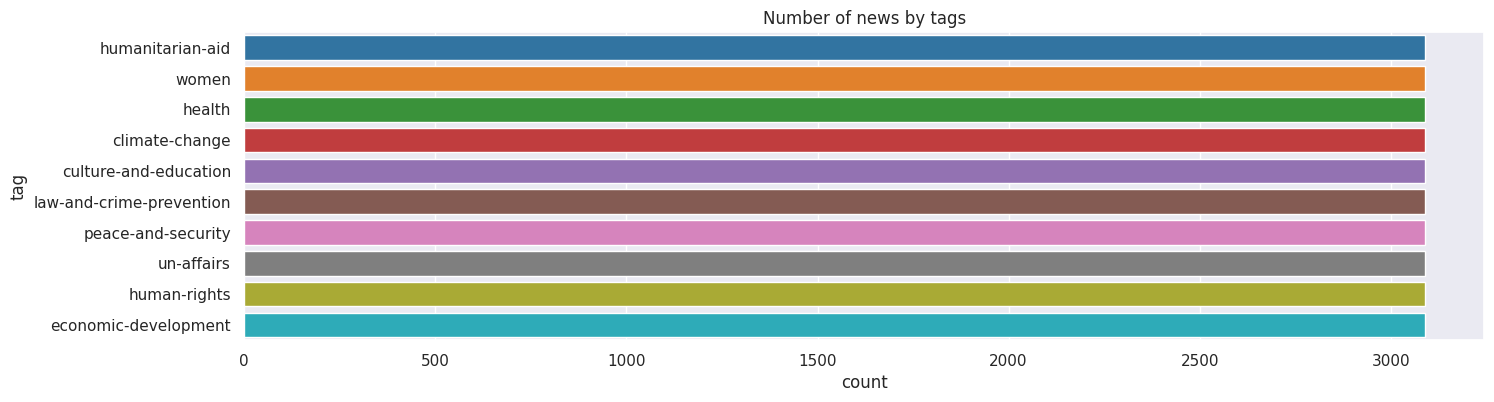

In [ ]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16,4))
sns.countplot(y=df["tag"], palette='tab10', ax=ax)
plt.title('Number of news by tags');

Сама по себе дата как строка не является признаком, однако ее компоненты могут играть важную роль в работе модели. Поэтому мы преобразуем строковую дату в формат datetime и добавим к нашим признакам год, месяц и день недели.

In [ ]:
df['date'] = pd.to_datetime(df.date)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.strftime("%B")
df['weekday'] = df['date'].dt.strftime('%A')

Какие выводы можно сделать по графикам ниже:
- Все новости относятся к разным годам: с 2003 по 2023. Без пропусков.
- Больше всего новостей приходится на 2017 год, а также на конец года - осень (Лидеры: Сентябрь и Октябрь). В течение недели больше всего новостей в среду-четверг, хотя различия при исключении выходных не кажутся большими.
- Меньше всего новостей в первые годы (2003 - 2006), в выходные.

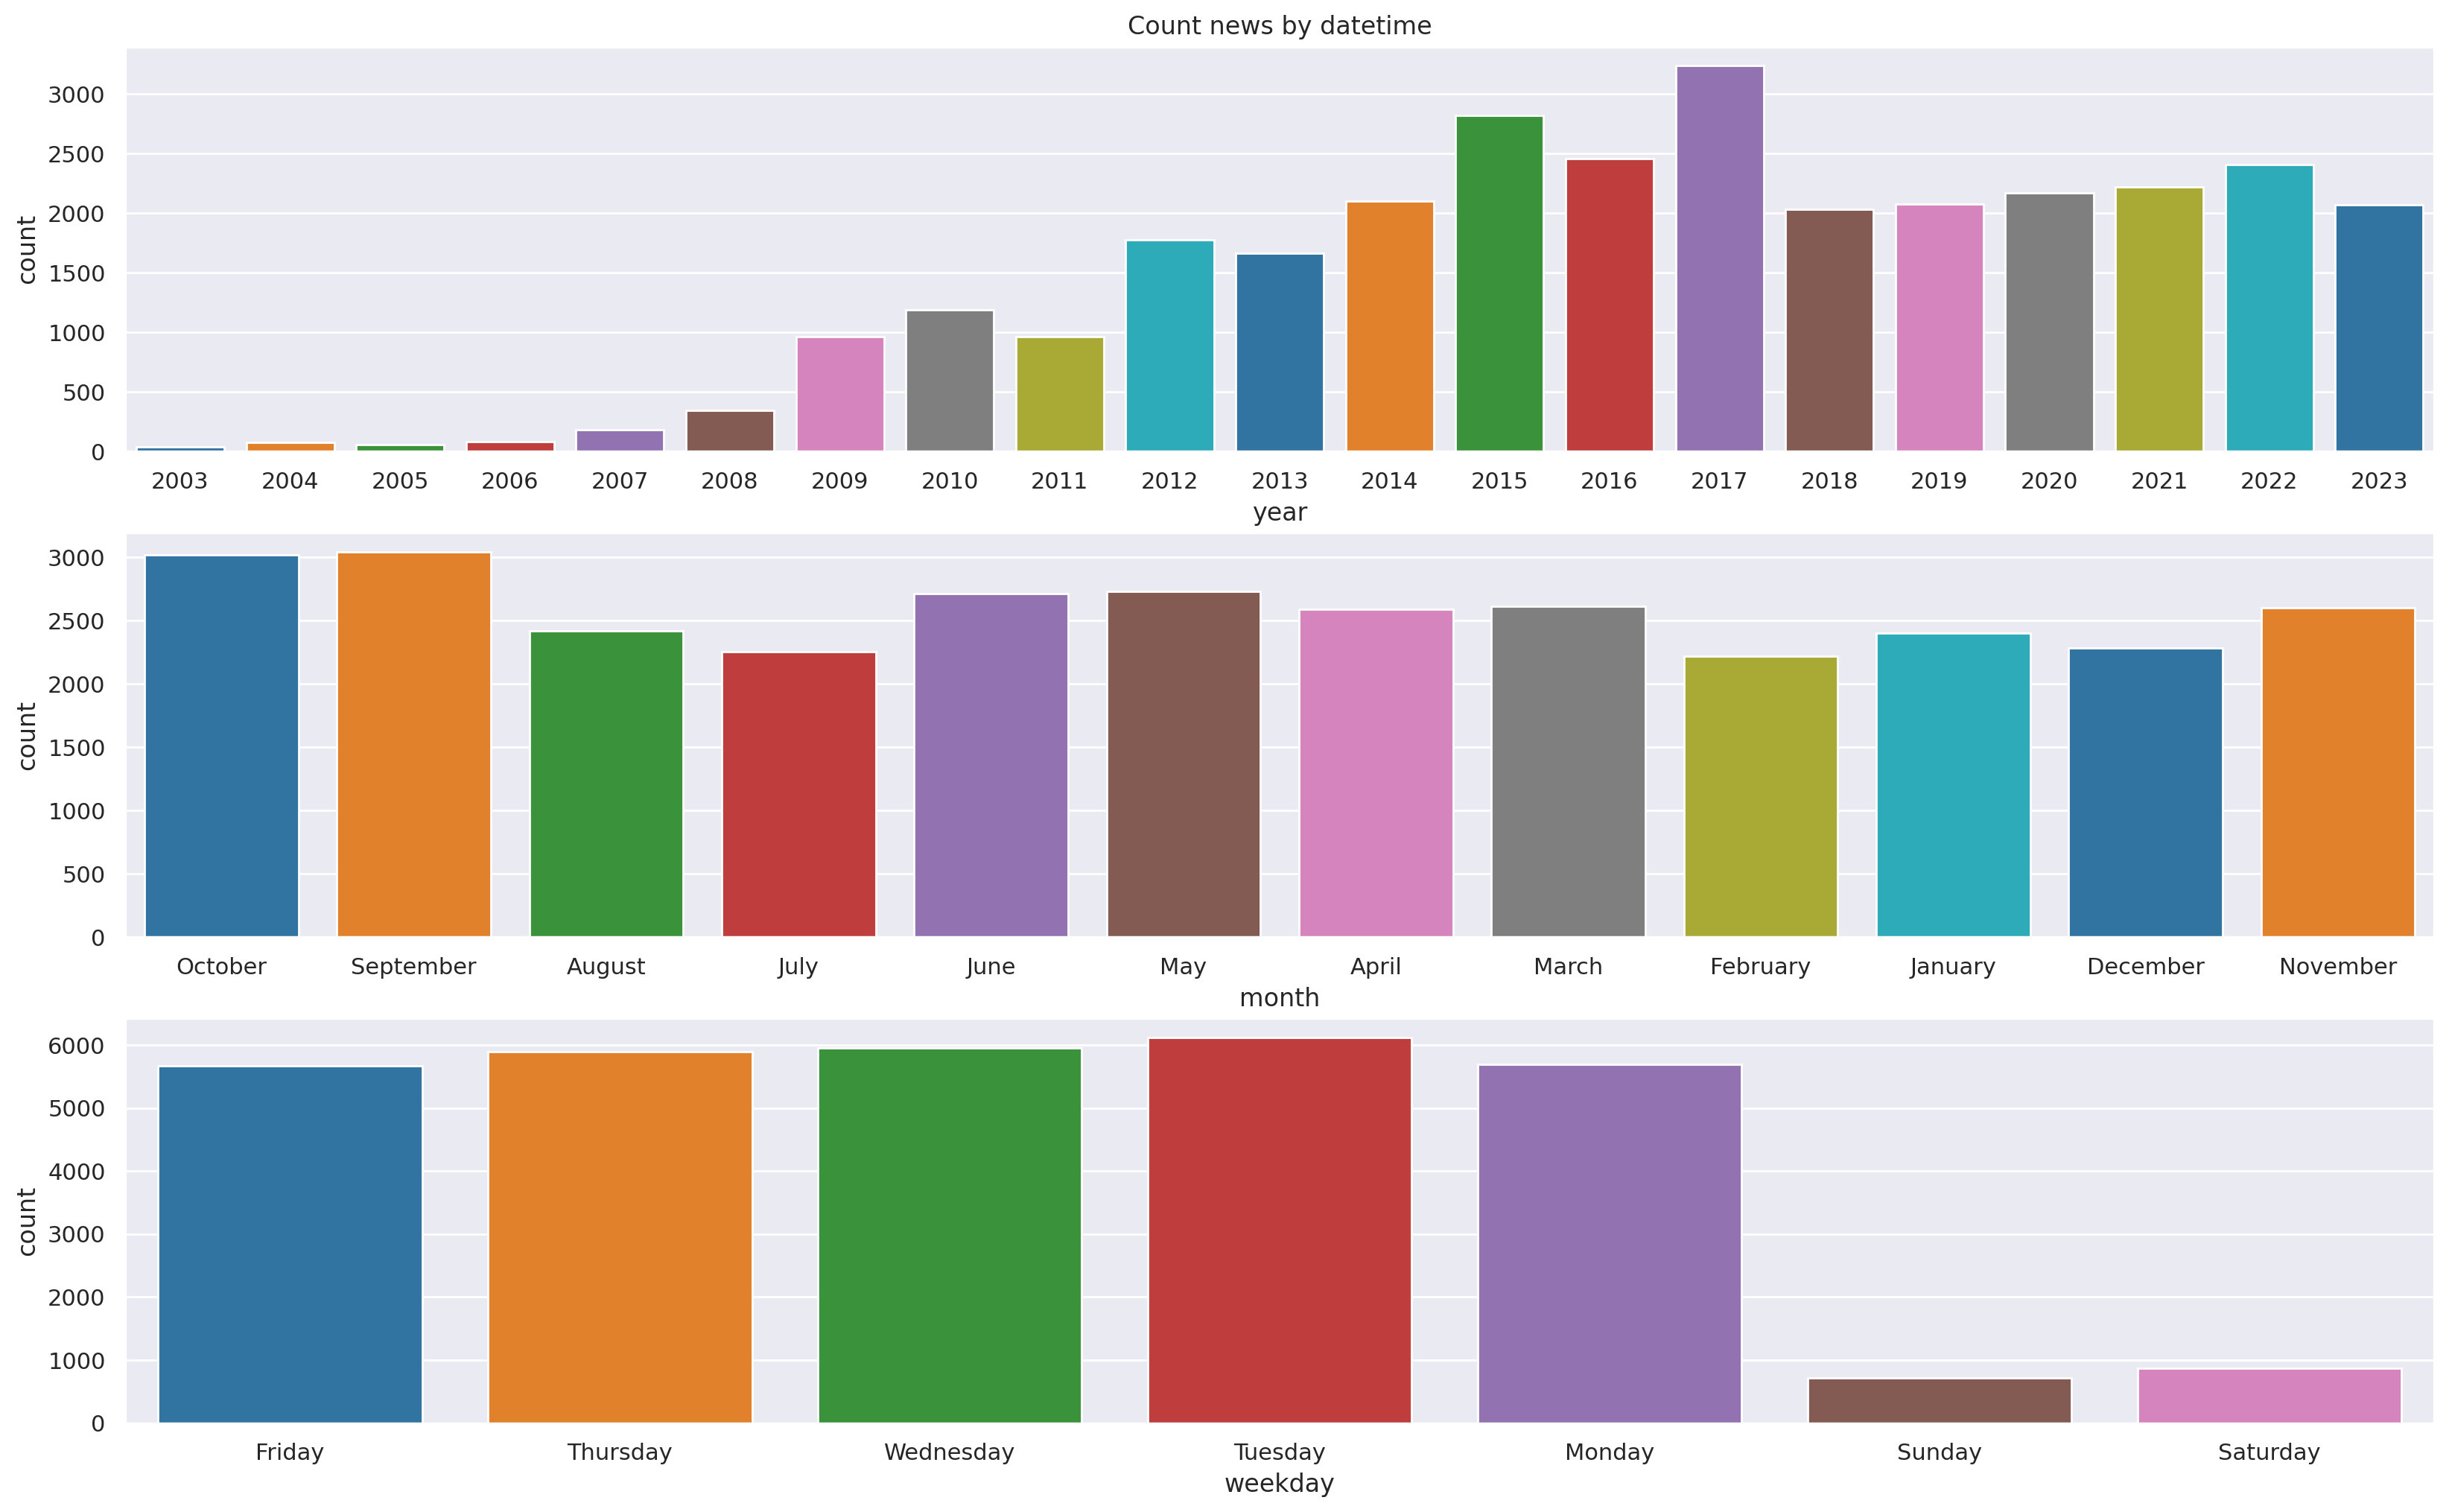

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12), dpi=200)
for ind, col in enumerate(['year', 'month', 'weekday']):
    sns.countplot(x=df[col], palette='tab10', ax=axs[ind]
                  #, order=df[col].value_counts(ascending=True).index
                  )
axs[0].set_title('Count news by datetime');

Посчитаем длину заголовков, вступительного и основного текста.

In [ ]:
df['len_title'] = df['title'].str.len()
df['len_abstract'] = df['abstract'].str.len()
df['len_text'] = df['text'].str.len()

Посмотрим, как они выглядят в разрезе каждой категории.

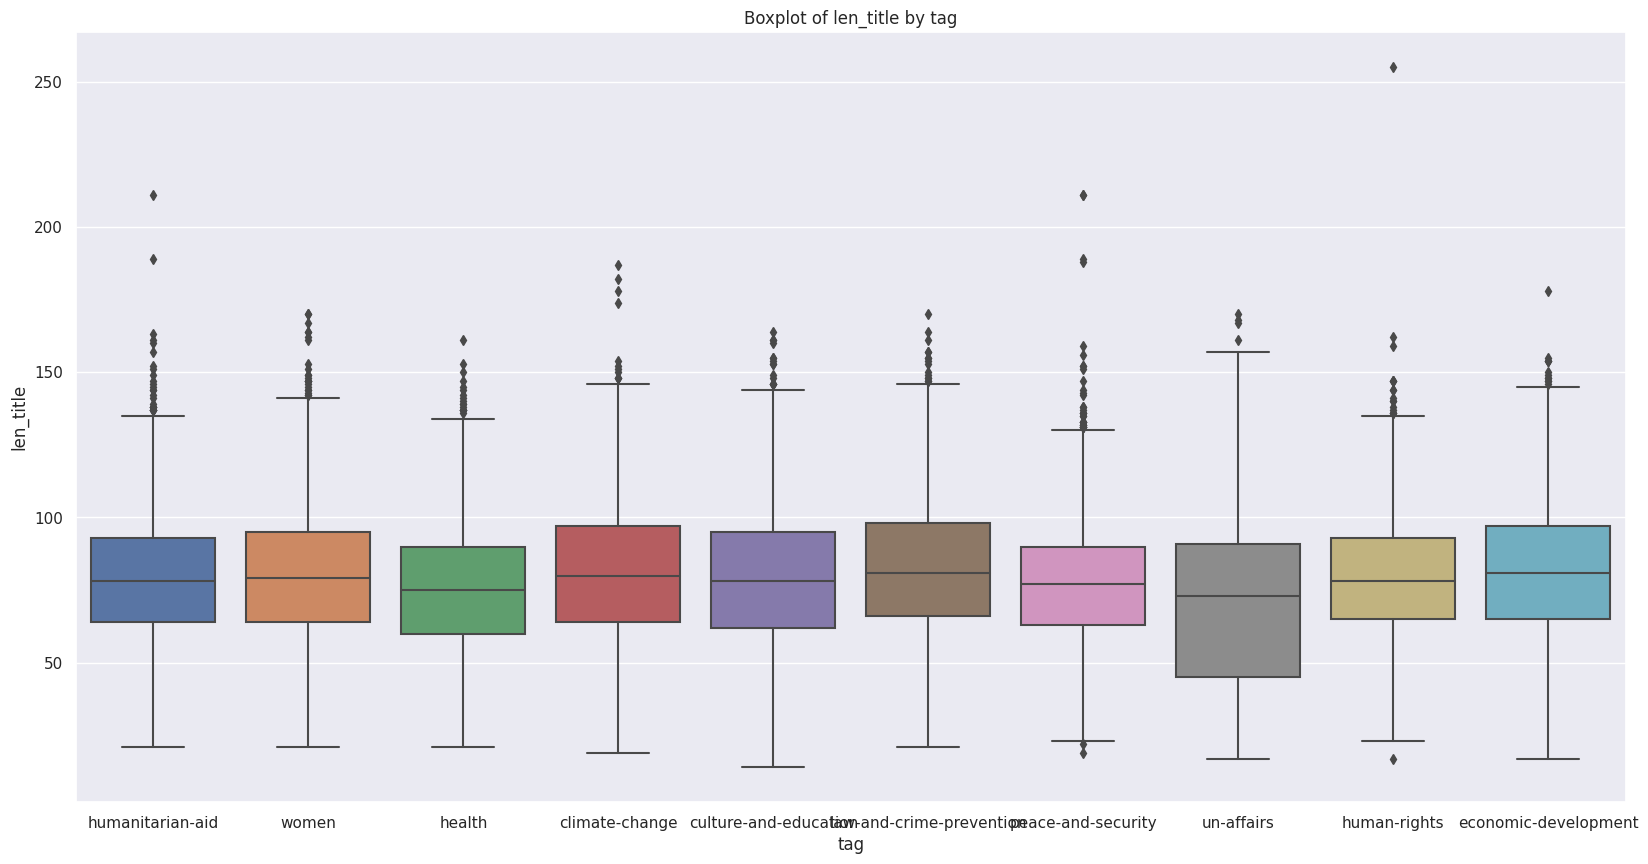

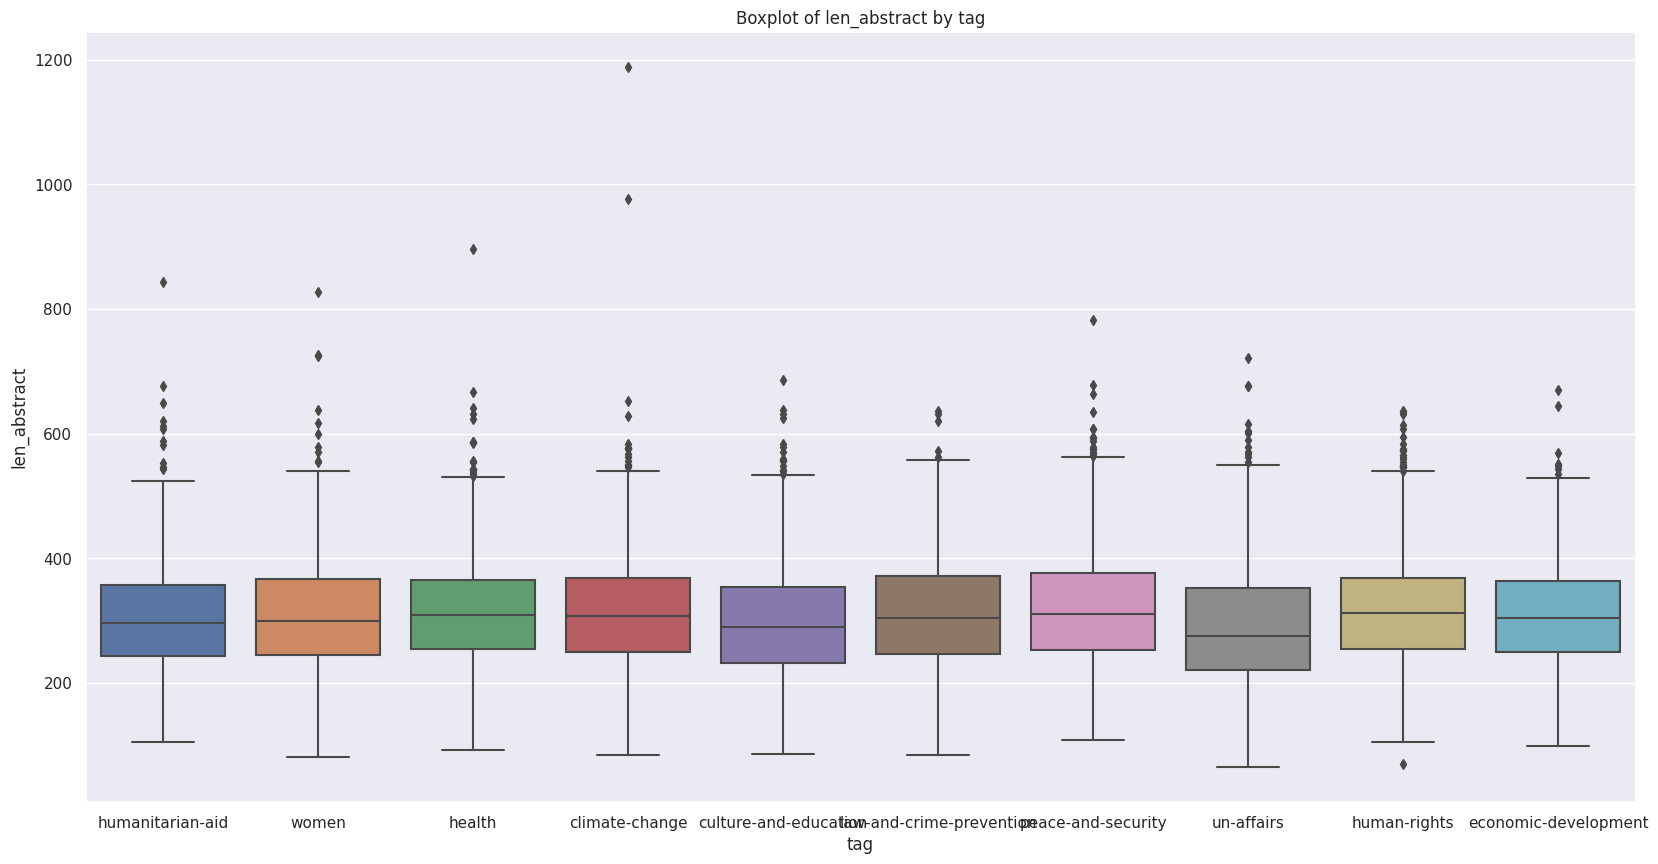

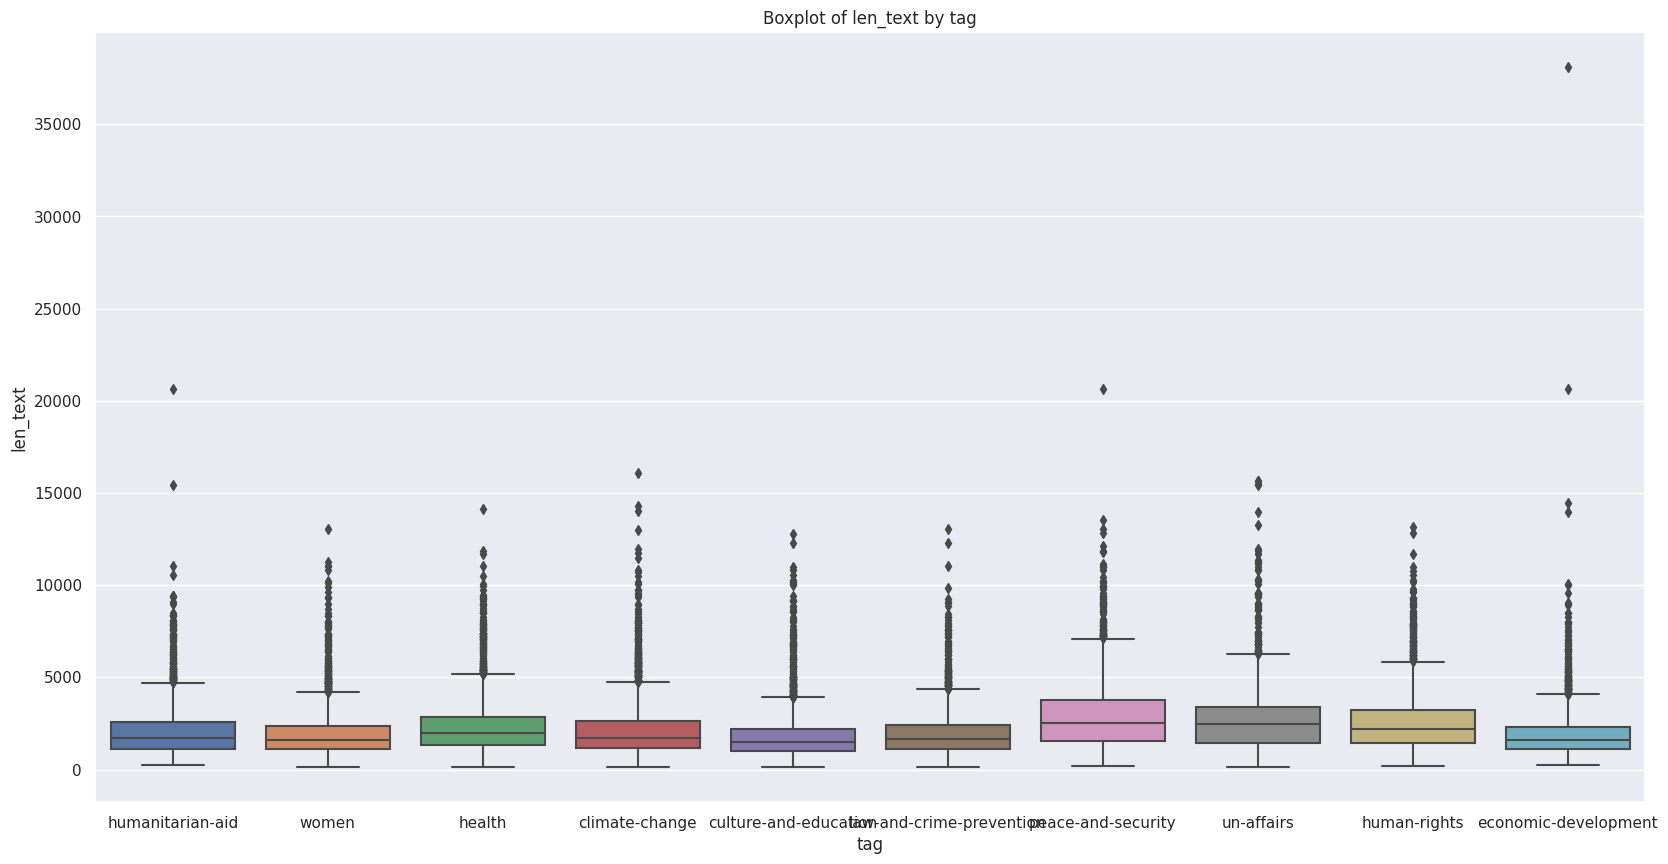

In [ ]:
for col in ['len_title', 'len_abstract', 'len_text']:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=100)
    sns.boxplot(x="tag", y=col, data=df, ax=ax)
    plt.title(f'Boxplot of {col} by tag');

Что можно заметить:
- В среднем длина заголовка по всем категориям около 65-70 символов
- Вступительный текст в среднем составляет 300 символов.
- Средняя длина основного текста варьирует чуть больше остальных параметров: примерно от 1500 до 2500 символов.
- Во всех параметрах и для всех категорий наблюдается большое количество заметные выбросов в сторону большего количества символов.

Посмотрим, какие ключевые слова чаще всего встречаются в статьях каждой тематики. Одной из гипотез является то, что статьи разных, но при этом близких тематик с одинаковыми ключевыми словами могут вносить негативный вклад в работу модели.

In [ ]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык'])

In [ ]:
for tag in df.tag.unique():
    words = df[df.tag == tag].title.str.split(' ').explode().values
    words = [word.lower() for word in words if word.lower() not in stop_words]

    wc = WordCloud(background_color="black", width=1600, height=800)
    wc.generate(" ".join(words))

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.set_title(f"Frequent words in {tag} tag", fontsize=30)
    ax.imshow(wc, alpha=0.98)


Output hidden; open in https://colab.research.google.com to view.

На сайте отсутствует счетчик просмотров или возможность комментирования. Но все равно ради интереса можно посмотреть распределение возраста статей. Тем более, что размах возрастов в нашем случае очень широк - от дня до 20 лет.

In [ ]:
df['lifetime'] = df['date'].apply(lambda x: (datetime.datetime.now() - x).total_seconds())
df['lifetime'] = df['lifetime'].apply(lambda x: divmod(x, 60)[0]) # lifetime in minutes

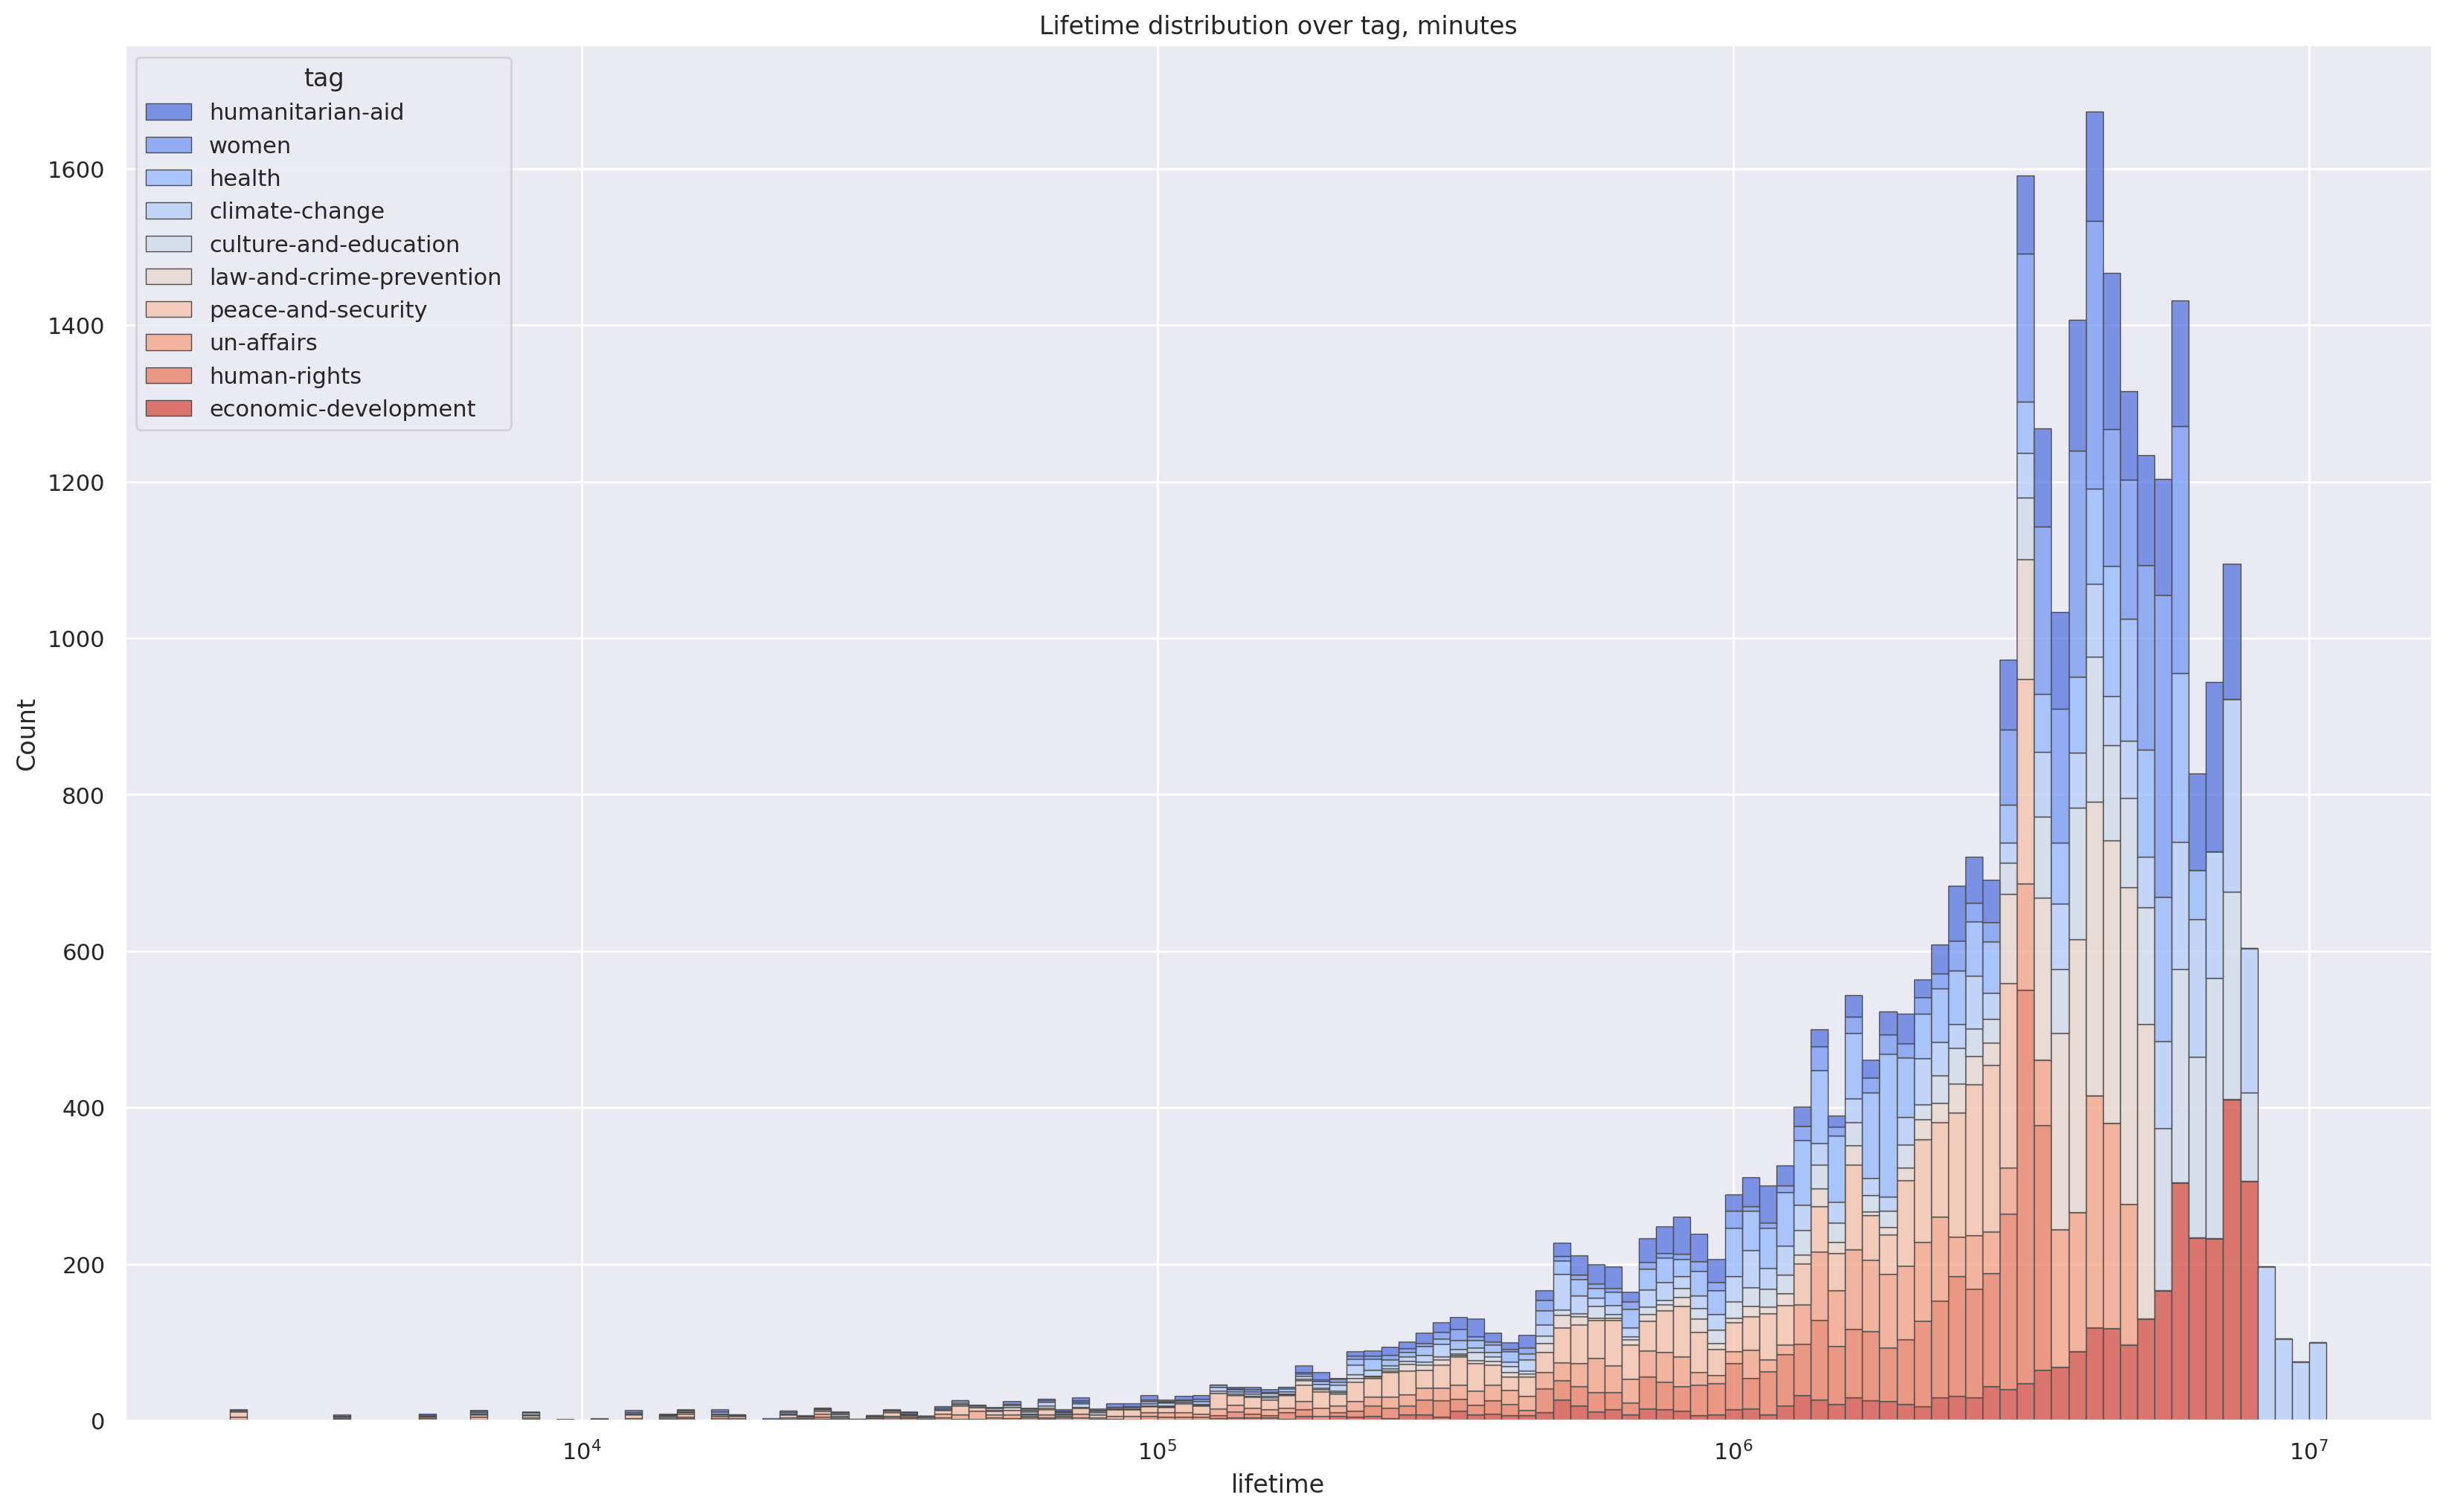

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 12), dpi=200)
sns.despine(fig)

sns.histplot(
    df,
    x="lifetime",
    hue="tag",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
    log_scale=True,
);
axs.set_title('Lifetime distribution over tag, minutes');

В датасете присутствуют как старые статьи, так и новые. И само распределение имеет смещённое вправо распределение.
Стоит отметить, что разные категории (теги) имеют разное количество статей, публикуемых в год. Это отражается не только на распределении возраста, но и на выборке в целом. Для некотрых категорий статьи в целом моложе, чем у категорий, в которых статьи публикуются реже.

### Выводы

Итак, на данном этапе мы провели первичный анализ датасета. Статьи распределены по тематикам равномерно. Все новости относятся к временному диапозону от 2003 до 2023 года. Максимум статей приходится на 2017 год. Больше всего новостей пишется в Сентябре и Октябре. По дням недели на текущих данных меньше всего новостей выходит в выходные и больше всего в середине недели, хотя различия в рабочую неделю небольшие.

В среднем длина заголовка по всем категориям около 65-70 символов. Длина вступительного текста в среднем составляет в среднем 300 символов. Длина основного текста варьирует больше и в среднем примерно составляет 1500-2000 символов. Все перечисленные текстовые признаки в каждом теге имели большое количество выбросов в сторону больших значений.

Мы также проанализировали основные ключевые слова, которые наводят на гипотезу о том, что статьи разных тематик могут быть сильно похожи по доминирующим ключевым словам и тем самым негативно влиять на модель. Это нужно будет иметь в виду при построоении модели.

Поскольку мы работаем с текстами, на этом этапе пока не столь очевидно, какие данные и по какой причине стоит считать выбросами, а какие - особенностями конкретной тематики. Поэтому это мы оставим на следующие этапы работы над проектом.